# Discharge, Reaccretion, and impacts of Supernovae (Part 1 /?):
## Concerning Satellite Infall
`-- Leo Lonzarich, 27 January 2022 // [Updated 7-2-22] --`

---

### Table of Contents
- [Defining Infall](#infall)
    - [Identifying Ram Pressures](#ramdis)



### General Comments on Data/Contents of this Noteboook
- This is the first installment of work tied to Spring 2022 research under **Professor Charlotte Christensen** (Grinnell College, IA)
- See `SimKeys.md` for comprensive explanation of intrinsic particle properties (as found when calling `[particles].keys()`) and standard units of measure.


**The Data (Lonzarich):**

- `discharged`: Gas particles that have been removed from the disk of their respective satellite galaxy. This includes both gas moved to halo, and that moved beyond the virial radius. (Properties given for **timestep after discharge event**.)
- `predischarged`: A collection of the same particles in `discharged`, but instead giving the properties of each particle prior to their discharge event (thereby allowing pre- and post-discharge comparisons).
- `heated`: Gas particles in `discharged` that experienced supernova(e) heating (functionally, their 'cooling' was turned off) in the timestep prior to being discharged. (Note: this dataset can be also be obtained by selecting particles from `discharged` with `sneHeated==True`.)
- `preheated`: Similar to `predischarged`; Consists of the same particles in `heated`, but with properties of each particle for the timestep prior to discharge.
<br><br>
- `accreted`: Gas particles in the halo or beyond the virial radius of a satellite that are accreted onto the satellite's disk. (Properties given for **timestep following accretion event**.) Note that this includes particles that were previously discharged from the satellite's disk, and those that were not. 
- `reaccreted`: A subset of `accreted`; Gas particles in the halo or beyond the virial radius of a satellite as a result of a prior discharge event that are reaccreted onto the satellite's disk. (Properties given for **timestep following reaccretion event**.)


In [9]:
import pylab
import pynbody
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from astropy import units
from astropy import constants as c

import warnings
warnings.filterwarnings("ignore")

from compiler import *
from analysis import * 
from ramdischarge import *

In [2]:
# helpful fix in case TeX breaks in pyplots.
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
# quick check to ensure all selected gas particles are accounted for.
path = f'{rootPath}Stellar_Feedback_Code/SNeData/discharged_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

print(len(keys), 'Available Keys:\n', *keys)

19 Available Keys:
 h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33


## Establishing Infall Distance to Satellite Host  <a class="infall" id="ram"></a>

#### Why?

To kickoff the second stage in SNe feedback analysis, we are first required to identify location during satellite infall for each gas particle. When a distant dwarf galaxy becomes gravitationally bound to a Milky-Way-mass host galaxy, it develops an approach vector oriented towards the COM of the host -- it is this approach to the host COM that we term "satellite infall", and it is the distance of the satellite's COM to the host's COM that we define as "point at infall". 

Thus, for each gas particle, we wish to find point at infall with the end goal being that this allows us to more readily discriminate between gas particles. What is more, however, we know from past work (see Akins et al. 2021) that ram pressure stripping (RPS) efficiency increases with proximity of a satellite galaxy to its host. Therefore, discriminating on point at infall presents a method for screening gas for RPS and possibly untangle RPS from SNe feedback stripping mechanisms.

#### How? 

Locating point at infall data, which we will lovingly term PAI (or `pai`), is a relatively straightforward excercise, and we will normalize `pai` by the virial radius of the host galaxy, `Rvir`, which will effectively give us a percent distance of a gas particle's satellite to the center of its host:

$$
pai = \frac{\text{radial distance from sat. to host}}{\text{virial radius of host}} .
$$
____
____

In [5]:
# importing gas selection:
predischarged, discharged, preheated, heated = read_all_discharged()
accreted, reaccreted = read_accreted()

> Returning (predischarged, discharged, preheated, heated) for all satellites <
> Returning (accreted, reaccreted) for all satellites <


In [19]:
discharged.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM', 'sat_Mvir', 'angle',
       'sneHeated', 'key'],
      dtype='object')

In [72]:
# callable derivation for satellite distance from host:
@pynbody.derived_array
def pai(gas):
    return np.array(np.sqrt((gas['host_Xc'] - gas['sat_Xc'])**2 
                            + (gas['host_Yc'] - gas['sat_Yc'])**2 
                            + (gas['host_Zc'] - gas['sat_Zc'])**2 
                           )/ gas['hostRvir']
                   )

# quick calc. for ubiquitous weights in plotting.
@pynbody.derived_array
def wt(*gas):
    if len(gas) == 1:
        return np.array(gas[0]['mass'] / gas[0]['mass'].sum())
    
    else:
        return np.array(gas[0]['mass'] / gas[1]['mass'].sum())

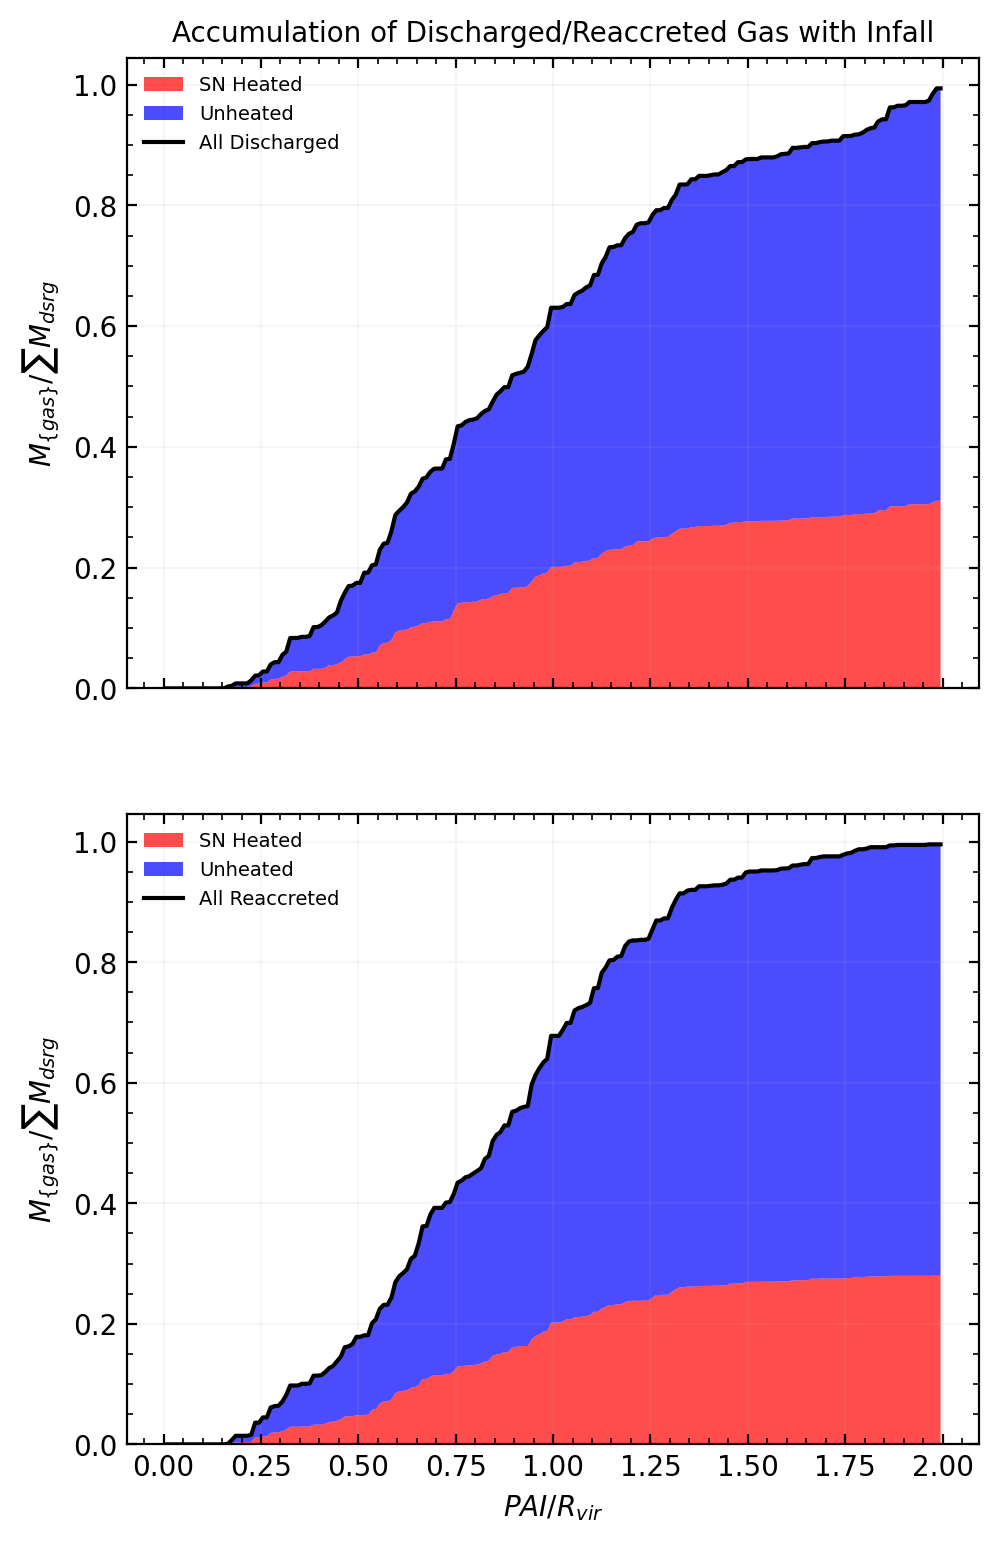

In [171]:
# Basic visualization of discharged/reaccreted gas as a function of POI.

hot = discharged[discharged.sneHeated==True]
cold = discharged[discharged.sneHeated==False]

bins = 200
fig, ax = plt.subplots(2,1, dpi=200, figsize=(5.5,9), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged), range=(0, 2))
sum2 = np.cumsum(y2)
ax[0].stackplot(bincenters, sum1, sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN Heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax[0].plot(bincenters, sum3, alpha=1.0, c='black', label='All Discharged')

# y4, x = np.histogram(pai(hot)/len(discharged), bins=bins, weights=wt(hot,discharged), range=(0, 2))
# ax.plot(bincenters, y4, alpha=1.0, c='black', label='All Discharged')

ax[0].set_title('Accumulation of Discharged/Reaccreted Gas with Infall', fontsize='medium')
# ax[0].set_xlabel(r'$PAI / R_{vir}$')
ax[0].set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[0].set_xlim(-0.1,4)
# ax[0].set_ylim(0,0.2)

ax[0].tick_params(direction='in', which='both', top=True, right=True)
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].grid(alpha=0.1, zorder=-1000)

ax[0].legend(frameon=False, fontsize=7)


hot = reaccreted[reaccreted.sneHeated==True]
cold = reaccreted[reaccreted.sneHeated==False]

y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,reaccreted), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,reaccreted), range=(0, 2))
sum2 = np.cumsum(y2)
ax[1].stackplot(bincenters, sum1, sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN Heated', 'Unheated'])         

y3, x = np.histogram(pai(reaccreted), bins=bins, weights=wt(reaccreted), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax[1].plot(bincenters, sum3, alpha=1.0, c='black', label='All Reaccreted')

ax[1].set_xlabel(r'$PAI / R_{vir}$')
ax[1].set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax[1].tick_params(direction='in', which='both', top=True, right=True)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].grid(alpha=0.1, zorder=-1000)

ax[1].legend(frameon=False, fontsize=7)

plt.show()

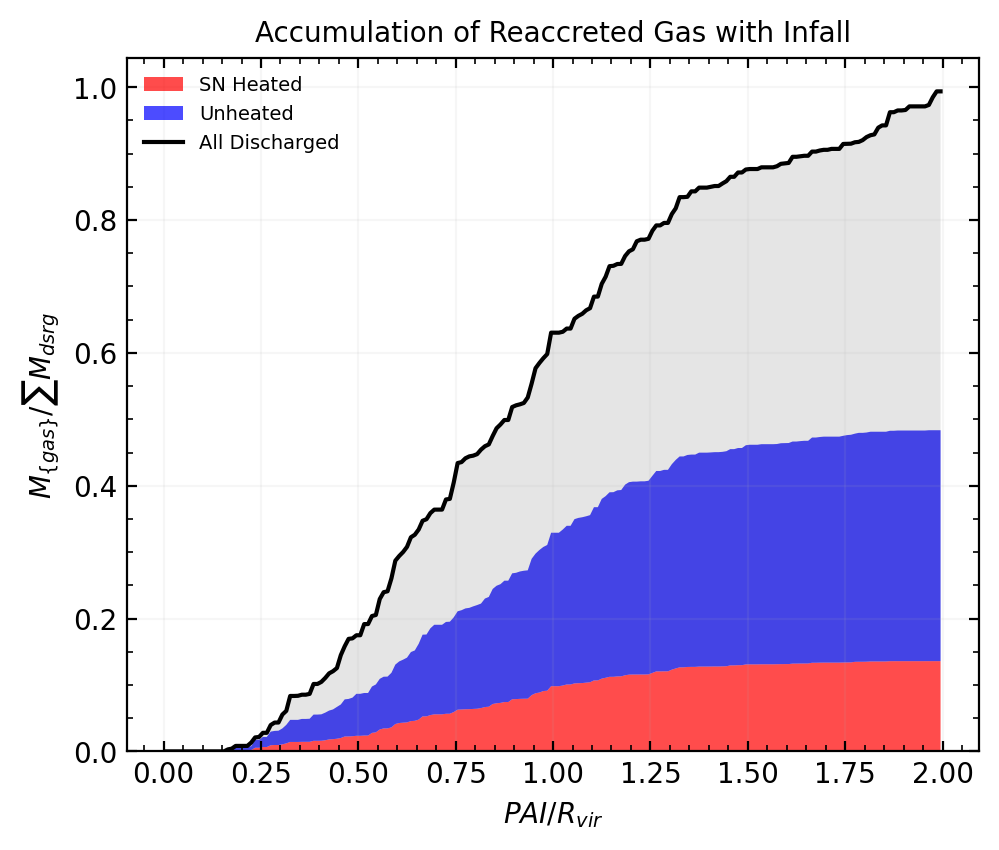

In [183]:
# Basic visualization of reaccreted gas as a function of POI.

hot = reaccreted[reaccreted.sneHeated==True]
cold = reaccreted[reaccreted.sneHeated==False]

bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged), range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1, sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN Heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3, alpha=1.0, c='black', label='All Discharged')

ax.fill_between(bincenters, sum1, sum3, color='k', ec=None, alpha=0.1)

ax.set_title('Accumulation of Reaccreted Gas with Infall', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

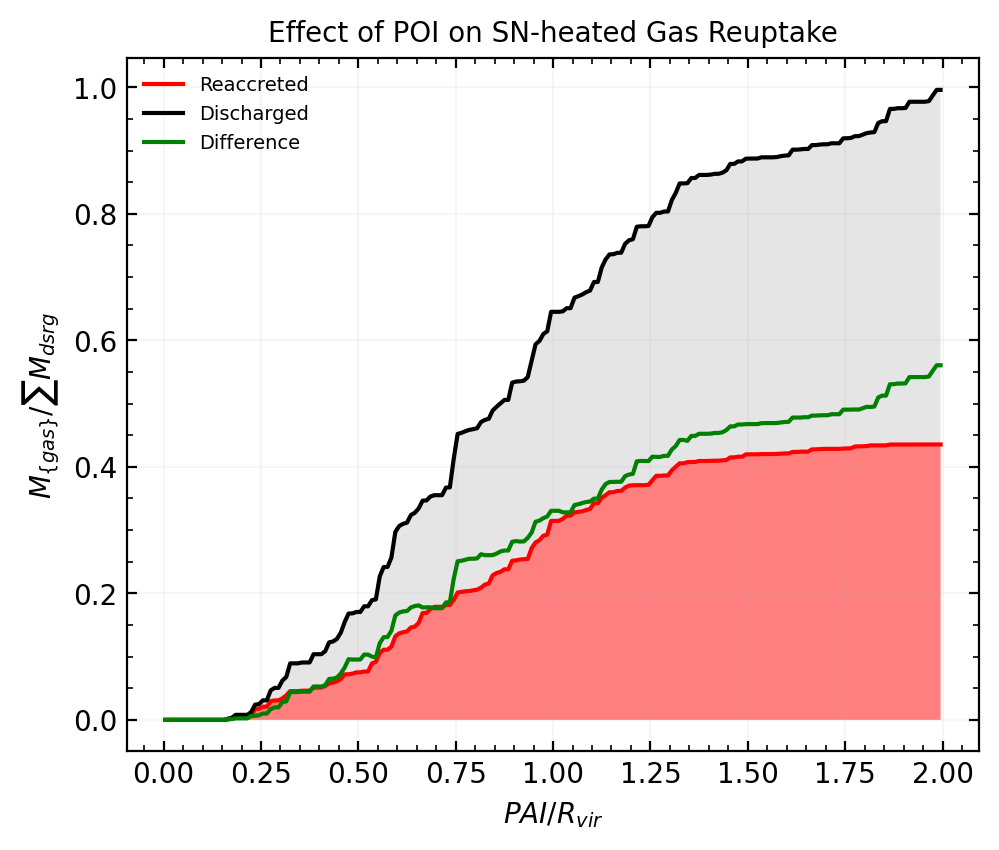

In [227]:
# Basic visualization of reaccreted gas as a function of POI.

hot_dsrg = discharged[discharged.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
hot_reac = reaccreted[reaccreted.sneHeated==True]
cold_reac = reaccreted[reaccreted.sneHeated==False]

bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac,hot_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)  
ax.plot(bincenters, sum1, alpha=1.0, c='red', label='Reaccreted')
ax.fill_between(bincenters, sum1, y2=0, color='r', ec=None, alpha=0.5)

y2, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)
ax.plot(bincenters, sum2, alpha=1.0, c='black', label='Discharged')
ax.fill_between(bincenters, sum1, sum2, color='k', ec=None, alpha=0.1)

ax.plot(bincenters, sum2-sum1, alpha=1.0, c='g', label='Difference')

ax.set_title('Effect of POI on SN-heated Gas Reuptake', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

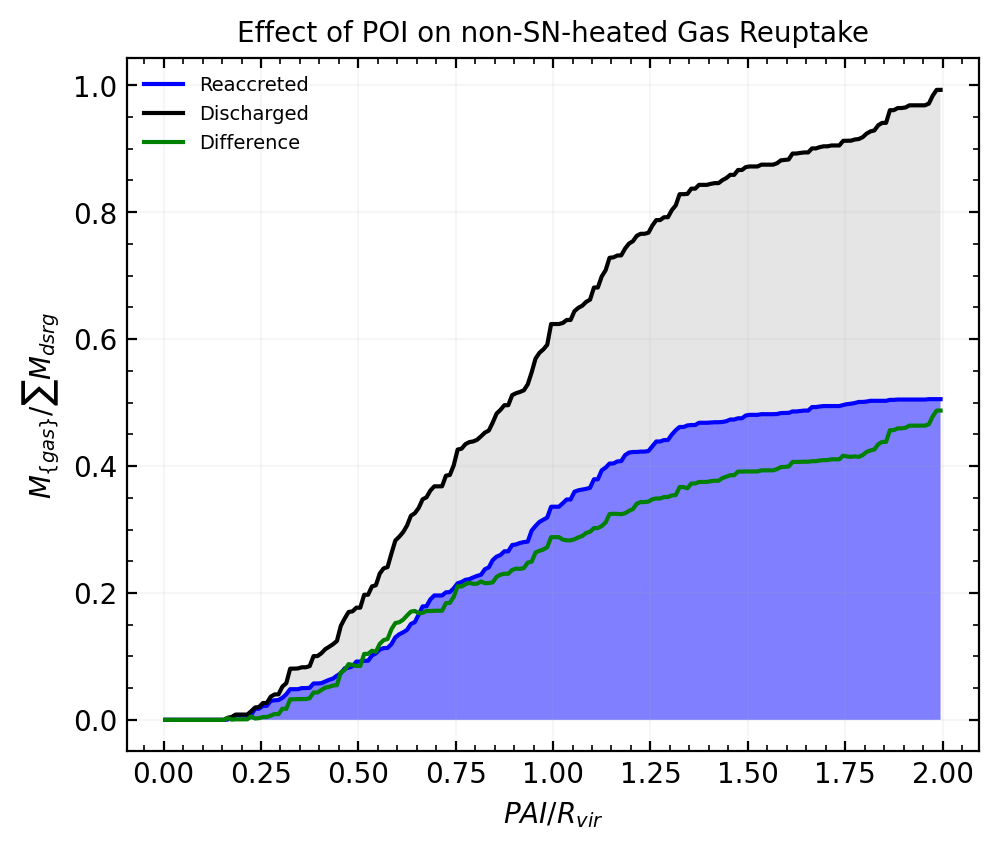

In [226]:
bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(cold_reac), bins=bins, weights=wt(cold_reac,cold_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)  
ax.plot(bincenters, sum1, alpha=1.0, c='b', label='Reaccreted')
ax.fill_between(bincenters, sum1, y2=0, color='b', ec=None, alpha=0.5)

y2, x = np.histogram(pai(cold_dsrg), bins=bins, weights=wt(cold_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)
ax.plot(bincenters, sum2, alpha=1.0, c='black', label='Discharged')
ax.fill_between(bincenters, sum1, sum2, color='k', ec=None, alpha=0.1)

ax.plot(bincenters, sum2-sum1, alpha=1.0, c='g', label='Difference')

ax.set_title('Effect of POI on non-SN-heated Gas Reuptake', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

### Code Testing <a class="anchor" id="proving"></a>

Testing out different data types and computations.